In [1]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=720)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')

# 全撈 
one_year_ago_str = '20210101'

# SQL 查詢 加權指數
query_twse = f"""
SELECT *
FROM daily_twse
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 細產業
query_sub_category = f"""
SELECT *
FROM sub_category
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
stock_df_raw = pd.read_sql(query_stock, engine)


結論

上市櫃後 第一天開盤買進 收盤



In [2]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')


# SQL 查詢 細產業
query_sub_category = f"""
SELECT *
FROM sub_category
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame

sub_category_list = pd.read_sql(query_sub_category, engine)



結論
只要有上市櫃股票 

當天開盤買 放到收盤 黑K就出掉

只要不是收跌 就抱著 
1. 抱到第八天收盤賣
2. 抱到跌破第一天開盤價往下3%賣掉

https://www.twse.com.tw/zh/listed/listed/apply-listing.html

https://www.tpex.org.tw/web/regular_emerging/apply_schedule/applicant/applicant_companies.php?l=zh-tw


In [172]:
# 先找上市第一筆
import numpy as np

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
new_stock_df = stock_df_raw[(stock_df_raw['Date'] > '2021-06-01') & (stock_df_raw['5MA'] == 0) & (stock_df_raw['10MA'] == 0) & (stock_df_raw['20MA'] == 0) & (stock_df_raw['60MA'] == 0) ]

new_stock_id = new_stock_df['證券代號'].unique().tolist()

total_earn = 0


cumsum_list = pd.DataFrame(columns=['loss_pen','cumsum1','cumsum2','len'])

hold_day = 7 # 7
loss_pen_list = np.arange(0.97, 0.98, 0.01)
earn1 = 0
earn2 = 0
earn3 = 0
earn4 = 0

for loss_pen in loss_pen_list: 
    new_stock_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','Day1開盤價','Day1收盤價','Day1Diff','Day8收盤價','earn1','earn2','loss_price','loss_type'])
    for stock_id in new_stock_id:
        
        new_stock = stock_df_raw[stock_df_raw['證券代號'] == stock_id]
        # new_stock = new_stock_df[new_stock_df['證券代號'] == stock_id]
        new_stock = new_stock.head(hold_day+1)
        if (len(new_stock) == hold_day+1):
            loss_price = 0
            loss_type = '0'
            day1_open_price = new_stock['開盤價'].iloc[0]
            day1_close_price = new_stock['收盤價'].iloc[0]

            day1_diff = day1_close_price - day1_open_price

            Date = new_stock['Date'].iloc[0]
            id = new_stock['證券代號'].iloc[0]
            name = new_stock['證券名稱'].iloc[0]

            close_price = new_stock['收盤價'].iloc[hold_day]
            # close_price2 = new_stock['收盤價'].iloc[hold_day+1]
            # close_price3 = new_stock['收盤價'].iloc[10]

            # 1. 直接放五天 中間不動作 開盤買
            earn1 = 100 * (close_price - day1_open_price)/day1_open_price

            # 2. 第一天收黑就不要了，其他的放五天
            if (day1_diff < 0):
                loss_type = '1'
                loss_price = day1_close_price
                earn2 =  100 * (loss_price-day1_open_price)/day1_open_price
            else :
                loss_data = new_stock[new_stock['收盤價'] < day1_open_price * loss_pen]

                # 盤中最低價跌破停損
                # loss_data = new_stock[(new_stock['最低價'] < day1_open_price*0.95) & (new_stock['收盤價'] != day1_close_price) ]

                if(len(loss_data) > 0):
                    loss_type = '2'
                    loss_price = loss_data['收盤價'].iloc[0]
                    earn2 = 100 * (loss_price - day1_open_price)/day1_open_price
                else:
                    loss_type = '3'
                    earn2 = 100 * (close_price - day1_open_price)/day1_open_price


            result_df = pd.DataFrame({
                'Date': [Date],
                '證券代號': [id],
                '證券名稱': [name],
                'Day1開盤價': [day1_open_price],
                'Day1收盤價': [day1_close_price],
                'Day1Diff':[day1_diff],
                'Day8收盤價': [close_price],
                'earn1': [earn1],
                'earn2': [earn2],
                'loss_price':[loss_price],
                'loss_type':[loss_type]
            })

            # 删除全为NA的列，避免可能出现的警告
            result_df.dropna(axis=1, how='all', inplace=True)
            if not result_df.empty:
                new_stock_list = pd.concat([new_stock_list, result_df], ignore_index=True)

    new_stock_list['cumsum1'] = new_stock_list['earn1'].cumsum()
    new_stock_list['cumsum2'] = new_stock_list['earn2'].cumsum()

    temp_df = pd.DataFrame({
        'loss_pen': [loss_pen],
        'cumsum1': [new_stock_list['cumsum1'].iloc[-1]],
        'cumsum2': [new_stock_list['cumsum2'].iloc[-1]],
        'len' : [len(new_stock_list)]
    })

    if not temp_df.empty:
        cumsum_list = pd.concat([cumsum_list, temp_df], ignore_index=True)

cumsum_list

C:\Users\USER\AppData\Local\Temp\ipykernel_9808\2319487176.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_stock_list = pd.concat([new_stock_list, result_df], ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_9808\2319487176.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cumsum_list = pd.concat([cumsum_list, temp_df], ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_9808\2319487176.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or

,loss_pen,cumsum1,cumsum2,len
0,0.97,411.191329,587.137929,142
1,0.98,411.191329,570.059476,142


In [174]:
new_stock_list[new_stock_list['證券代號'] == '6914']

,Date,證券代號,證券名稱,Day1開盤價,Day1收盤價,Day1Diff,Day8收盤價,earn1,earn2,loss_price,loss_type,cumsum1,cumsum2
121,2024-05-03,6914,阜爾運通,198.0,188.5,-9.5,194.0,-2.020202,-4.79798,188.5,1,297.318049,432.816921


In [170]:
new_stock_list[new_stock_list['loss_type'] == '3'].sort_values(by='earn2').head(30)[['Date', '證券名稱','Day1開盤價', 'Day1收盤價','loss_price','Day8收盤價','earn2','loss_type']]


,Date,證券名稱,Day1開盤價,Day1收盤價,loss_price,Day8收盤價,earn2,loss_type
79,2023-06-21,雄順,33.00,34.95,0,33.10,0.303030,3
139,2024-08-13,台新藥,39.05,41.95,0,39.50,1.152369,3
32,2022-05-09,台灣精銳,203.00,212.50,0,206.00,1.477833,3
59,2022-12-15,展達,39.40,48.00,0,40.05,1.649746,3
132,2024-06-13,大武山,50.20,53.10,0,51.20,1.992032,3
51,2022-11-03,精拓科,44.00,44.60,0,45.45,3.295455,3
109,2024-02-02,進能服,30.00,31.90,0,31.20,4.000000,3
86,2023-10-19,達發,410.00,415.00,0,427.00,4.146341,3
98,2023-12-05,伯鑫,149.50,171.00,0,156.00,4.347826,3
88,2023-10-27,鑫傳,68.50,72.00,0,71.90,4.963504,3


In [171]:
# 先找上市第一筆

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
new_stock_df = stock_df_raw[(stock_df_raw['Date'] > '2021-06-01') & (stock_df_raw['5MA'] == 0) & (stock_df_raw['10MA'] == 0) & (stock_df_raw['20MA'] == 0) & (stock_df_raw['60MA'] == 0) ]

new_stock_id = new_stock_df['證券代號'].unique().tolist()

total_earn = 0


cumsum_list = pd.DataFrame(columns=['hold_day','cumsum1','cumsum2','cumsum3','cumsum4','len'])

hold_day = 5
hold_day_list = list(range(7, 8, 1)) # 77 
earn1 = 0
earn2 = 0
earn3 = 0
earn4 = 0

for hold_day in hold_day_list: 
    new_stock_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','Day1開盤價','Day1收盤價','Day1Diff','收盤價','close_price3','earn1','earn2','earn3','earn4'])
    for stock_id in new_stock_id:
        
        new_stock = stock_df_raw[stock_df_raw['證券代號'] == stock_id]
        # new_stock = new_stock_df[new_stock_df['證券代號'] == stock_id]

        if (len(new_stock) > 10):
            day1_open_price = new_stock['開盤價'].iloc[0]
            day1_close_price = new_stock['收盤價'].iloc[0]

            day1_diff = day1_close_price - day1_open_price

            Date = new_stock['Date'].iloc[0]
            id = new_stock['證券代號'].iloc[0]
            name = new_stock['證券名稱'].iloc[0]

            close_price = new_stock['收盤價'].iloc[hold_day]
            close_price2 = new_stock['收盤價'].iloc[hold_day+1]
            close_price3 = new_stock['收盤價'].iloc[10]

            # 1. 直接放五天 中間不動作 開盤買
            earn1 = 100 * (close_price - day1_open_price)/day1_open_price

            # 2. 第一天收黑就不要了，其他的放五天
            if (day1_diff < 0):
                earn2 =  100 * day1_diff/day1_open_price
            else :
                earn2 = 100 * (close_price - day1_open_price)/day1_open_price

            day2_open_price = new_stock['開盤價'].iloc[2]

            # 3. 第二天開高再進場
            if (day2_open_price > day1_close_price):
                earn3 = 100 * (close_price2 - day2_open_price)/day2_open_price
            else:
                earn3 = 0


            # 4. 直接放五天 中間不動作 收盤買
            earn4 = 100 * (close_price - day1_close_price)/day1_close_price

            result_df = pd.DataFrame({
                'Date': [Date],
                '證券代號': [id],
                '證券名稱': [name],
                'Day1開盤價': [day1_open_price],
                'Day1收盤價': [day1_close_price],
                'Day1Diff':[day1_diff],
                '收盤價': [close_price],
                'close_price3' : [close_price3],
                'earn1': [earn1],
                'earn2': [earn2],
                'earn3': [earn3],
                'earn4': [earn4]
            })

            # 删除全为NA的列，避免可能出现的警告
            result_df.dropna(axis=1, how='all', inplace=True)
            if not result_df.empty:
                new_stock_list = pd.concat([new_stock_list, result_df], ignore_index=True)

    new_stock_list['cumsum1'] = new_stock_list['earn1'].cumsum()
    new_stock_list['cumsum2'] = new_stock_list['earn2'].cumsum()
    new_stock_list['cumsum3'] = new_stock_list['earn3'].cumsum()
    new_stock_list['cumsum4'] = new_stock_list['earn4'].cumsum()

    temp_df = pd.DataFrame({
        'hold_day': [hold_day],
        'cumsum1': [new_stock_list['cumsum1'].iloc[-1]],
        'cumsum2': [new_stock_list['cumsum2'].iloc[-1]],
        'cumsum3': [new_stock_list['cumsum3'].iloc[-1]],
        'cumsum4': [new_stock_list['cumsum4'].iloc[-1]],
        'len' : [len(new_stock_list)]
    })

    if not temp_df.empty:
        cumsum_list = pd.concat([cumsum_list, temp_df], ignore_index=True)

cumsum_list

C:\Users\USER\AppData\Local\Temp\ipykernel_9808\223792240.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_stock_list = pd.concat([new_stock_list, result_df], ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_9808\223792240.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cumsum_list = pd.concat([cumsum_list, temp_df], ignore_index=True)


,hold_day,cumsum1,cumsum2,cumsum3,cumsum4,len
0,7,411.191329,548.682309,179.430327,78.20239,142


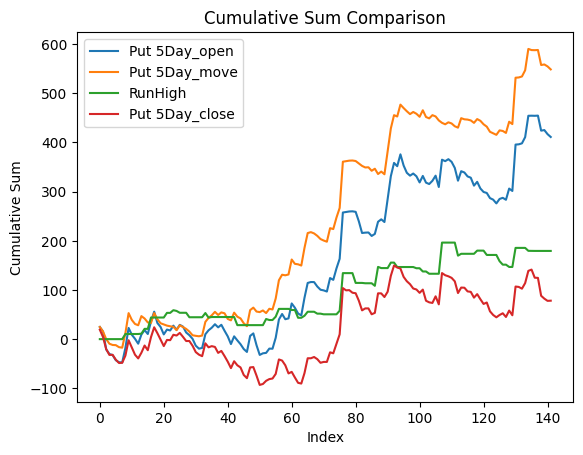

In [117]:
import matplotlib.pyplot as plt

# 繪製三條折線
new_stock_list['cumsum1'].plot(label='Put 5Day_open')
new_stock_list['cumsum2'].plot(label='Put 5Day_move')
new_stock_list['cumsum3'].plot(label='RunHigh')
new_stock_list['cumsum4'].plot(label='Put 5Day_close')

# 添加標題和圖例
plt.title('Cumulative Sum Comparison')
plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.legend()

# 顯示圖表
plt.show()
